## Importing Necessary Libraries

In [70]:
from os import listdir
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import csr_matrix
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Importing Dataset

#### Downloading Dataset

In [ ]:
import wget
wget.download('https://www.cs.cmu.edu/afs/cs/project/theo-11/www/naive-bayes/20_newsgroups.tar.gz')

#### Extracting Dataset

In [ ]:
import tarfile
tar_path = '20_newsgroups.tar.gz'
extract_to = '20_newsgroups'

with tarfile.open(tar_path, 'r:gz') as tar_ref:
    tar_ref.extractall(extract_to)

In [71]:
dataset = '20_newsgroups'

In [72]:
def create_folder_content_dict(root_folder):
    folder_content_dict = {}
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            folder_content_dict[folder_name] = {}
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='ISO-8859-1') as file:
                        folder_content_dict[folder_name][file_name] = file.read()
    return folder_content_dict

In [73]:
dict = create_folder_content_dict(dataset)
print(dict.keys())

values_length = {key: len(value) for key, value in dict.items()}
print(values_length)

dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])
{'talk.politics.mideast': 1000, 'rec.autos': 1000, 'comp.sys.mac.hardware': 1000, 'alt.atheism': 1000, 'rec.sport.baseball': 1000, 'comp.os.ms-windows.misc': 1000, 'rec.sport.hockey': 1000, 'sci.crypt': 1000, 'sci.med': 1000, 'talk.politics.misc': 1000, 'rec.motorcycles': 1000, 'comp.windows.x': 1000, 'comp.graphics': 1000, 'comp.sys.ibm.pc.hardware': 1000, 'sci.electronics': 1000, 'talk.politics.guns': 1000, 'sci.space': 1000, 'soc.religion.christian': 997, 'misc.forsale': 1000, 'talk.religion.misc': 1000}


## Data Preprocessing

In [74]:
def preprocess_text(text):
    # Converting text to lowercase
    text = text.lower()
    
    # Removing special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenizing the text
    tokens = word_tokenize(text)
    
    # Removing stopwords
    stop_words = list(stopwords.words('english'))
    newStopWords = ['xref','path','from','cantaloupesrvcscmuedu','hmcsbrownedu','subject','inreplyto','hernlemchessncsuedus','message',
                    'mon','tue','wed','thu','fri','sat','sun',
                    'jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec',
                    'sender','newscsbrownedu','organization','dept','computer','science','brown','university','references',
                    'aprncsuedu','date','gmt','lines','line','hernlem','writes','day','several','occupation']
    stop_words.extend(newStopWords)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text


def process_folder_content_dict(dict):
    processed_folder_content_dict = {}
    for folder, files in dict.items():
        processed_folder_content_dict[folder] = []
        for file_name, content in files.items():
            preprocessed_content = preprocess_text(content)
            processed_folder_content_dict[folder].append(preprocessed_content)
    return processed_folder_content_dict
processed_folder_content = process_folder_content_dict(dict)

## Data Exploration

In [75]:
df = pd.DataFrame([(k, v) for k, val in processed_folder_content.items() for v in val], columns=['News_Groups', 'Texts'])
print(df.shape)

(19997, 2)


In [76]:
print(df.head)

<bound method NDFrame.head of                  News_Groups  \
0      talk.politics.mideast   
1      talk.politics.mideast   
2      talk.politics.mideast   
3      talk.politics.mideast   
4      talk.politics.mideast   
...                      ...   
19992     talk.religion.misc   
19993     talk.religion.misc   
19994     talk.religion.misc   
19995     talk.religion.misc   
19996     talk.religion.misc   

                                                   Texts  
0      newsgroups talkpoliticsmideast cantaloupesrvcs...  
1      talkpoliticsmideast talkpoliticsmisc soccultur...  
2      talkpoliticsmideast socculturegreek socculture...  
3      cantaloupesrvcscmueducrabapplesrvcscmuedufsece...  
4      socculturearabic talkpoliticsmideast soccultur...  
...                                                  ...  
19992  talkreligionmisc talkpoliticsmisc sciskeptic n...  
19993  talkreligionmisc talkreligionnewage altpagan c...  
19994  sciskeptic talkpoliticsmisc talkreligionmisc n.

In [77]:
print(df.describe())

                  News_Groups  \
count                   19997   
unique                     20   
top     talk.politics.mideast   
freq                     1000   

                                                    Texts  
count                                               19997  
unique                                              19450  
top     newsgroups talkpoliticsguns cantaloupesrvcscmu...  
freq                                                    5  


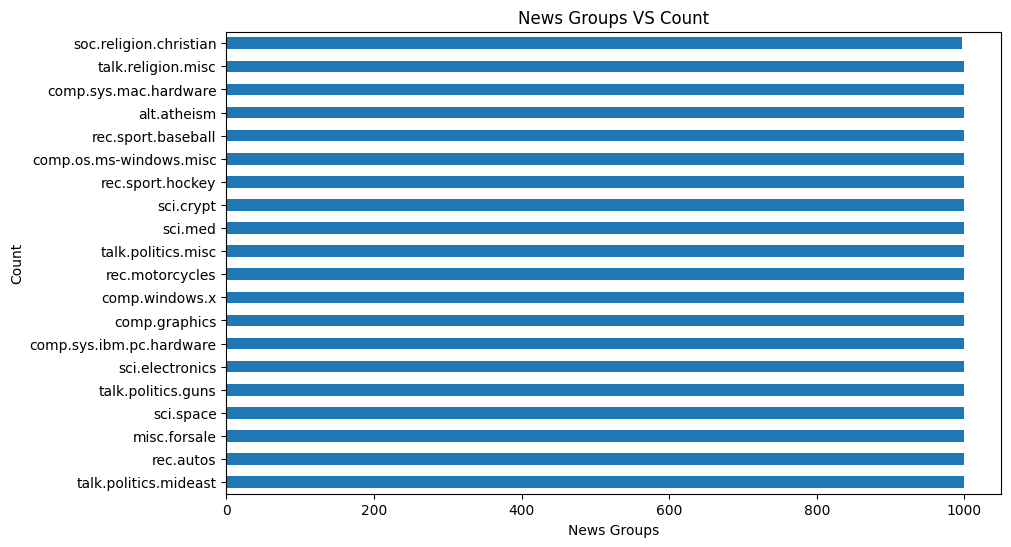

In [78]:
plt.figure(figsize=(10, 6))
df['News_Groups'].value_counts().plot(kind='barh')
plt.title('News Groups VS Count')
plt.xlabel('News Groups')
plt.ylabel('Count')
plt.show()

## Splitting Data

In [79]:
vectorizer = TfidfVectorizer()
train_data = []
test_data = []
for key, values in processed_folder_content.items():
    l = int(len(values)/2)
    train_values = values[:l]
    test_values = values[l:]
    train_data.extend([(key, value) for value in train_values])
    test_data.extend([(key, value) for value in test_values])

train_data = pd.DataFrame(train_data, columns=['News_Groups', 'Texts'])
y_train = pd.Series(train_data['News_Groups'])
X_train = vectorizer.fit_transform(train_data['Texts'])
print(train_data.shape)

test_data = pd.DataFrame(test_data, columns=['News_Groups', 'Texts'])
X_test = vectorizer.transform(test_data['Texts'])
y_test = pd.Series(test_data['News_Groups'])
print(test_data.shape)

(9998, 2)
(9999, 2)


## Implementing Multinominal Naive Bayes using Sklearn

In [80]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9027902790279028


### Classification Report - Multinominal Naive Bayes(using Sklearn)

In [81]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')
accuracy = accuracy_score(y_train, classifier.predict(X_train))
print(f'Train Accuracy: {accuracy:.2f}')
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Test Accuracy: 0.90
Train Accuracy: 0.96
Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.76      0.83      0.79       500
           comp.graphics       0.90      0.87      0.89       500
 comp.os.ms-windows.misc       0.92      0.91      0.91       500
comp.sys.ibm.pc.hardware       0.83      0.91      0.87       500
   comp.sys.mac.hardware       0.95      0.95      0.95       500
          comp.windows.x       0.95      0.91      0.93       500
            misc.forsale       0.93      0.84      0.88       500
               rec.autos       0.95      0.95      0.95       500
         rec.motorcycles       0.99      0.97      0.98       500
      rec.sport.baseball       0.99      0.99      0.99       500
        rec.sport.hockey       0.98      0.99      0.99       500
               sci.crypt       0.93      0.99      0.96       500
         sci.electronics       0.94      0.90      0.92       500
          

### Multinominal Naive Bayes Confusion Matrix using Sklearn

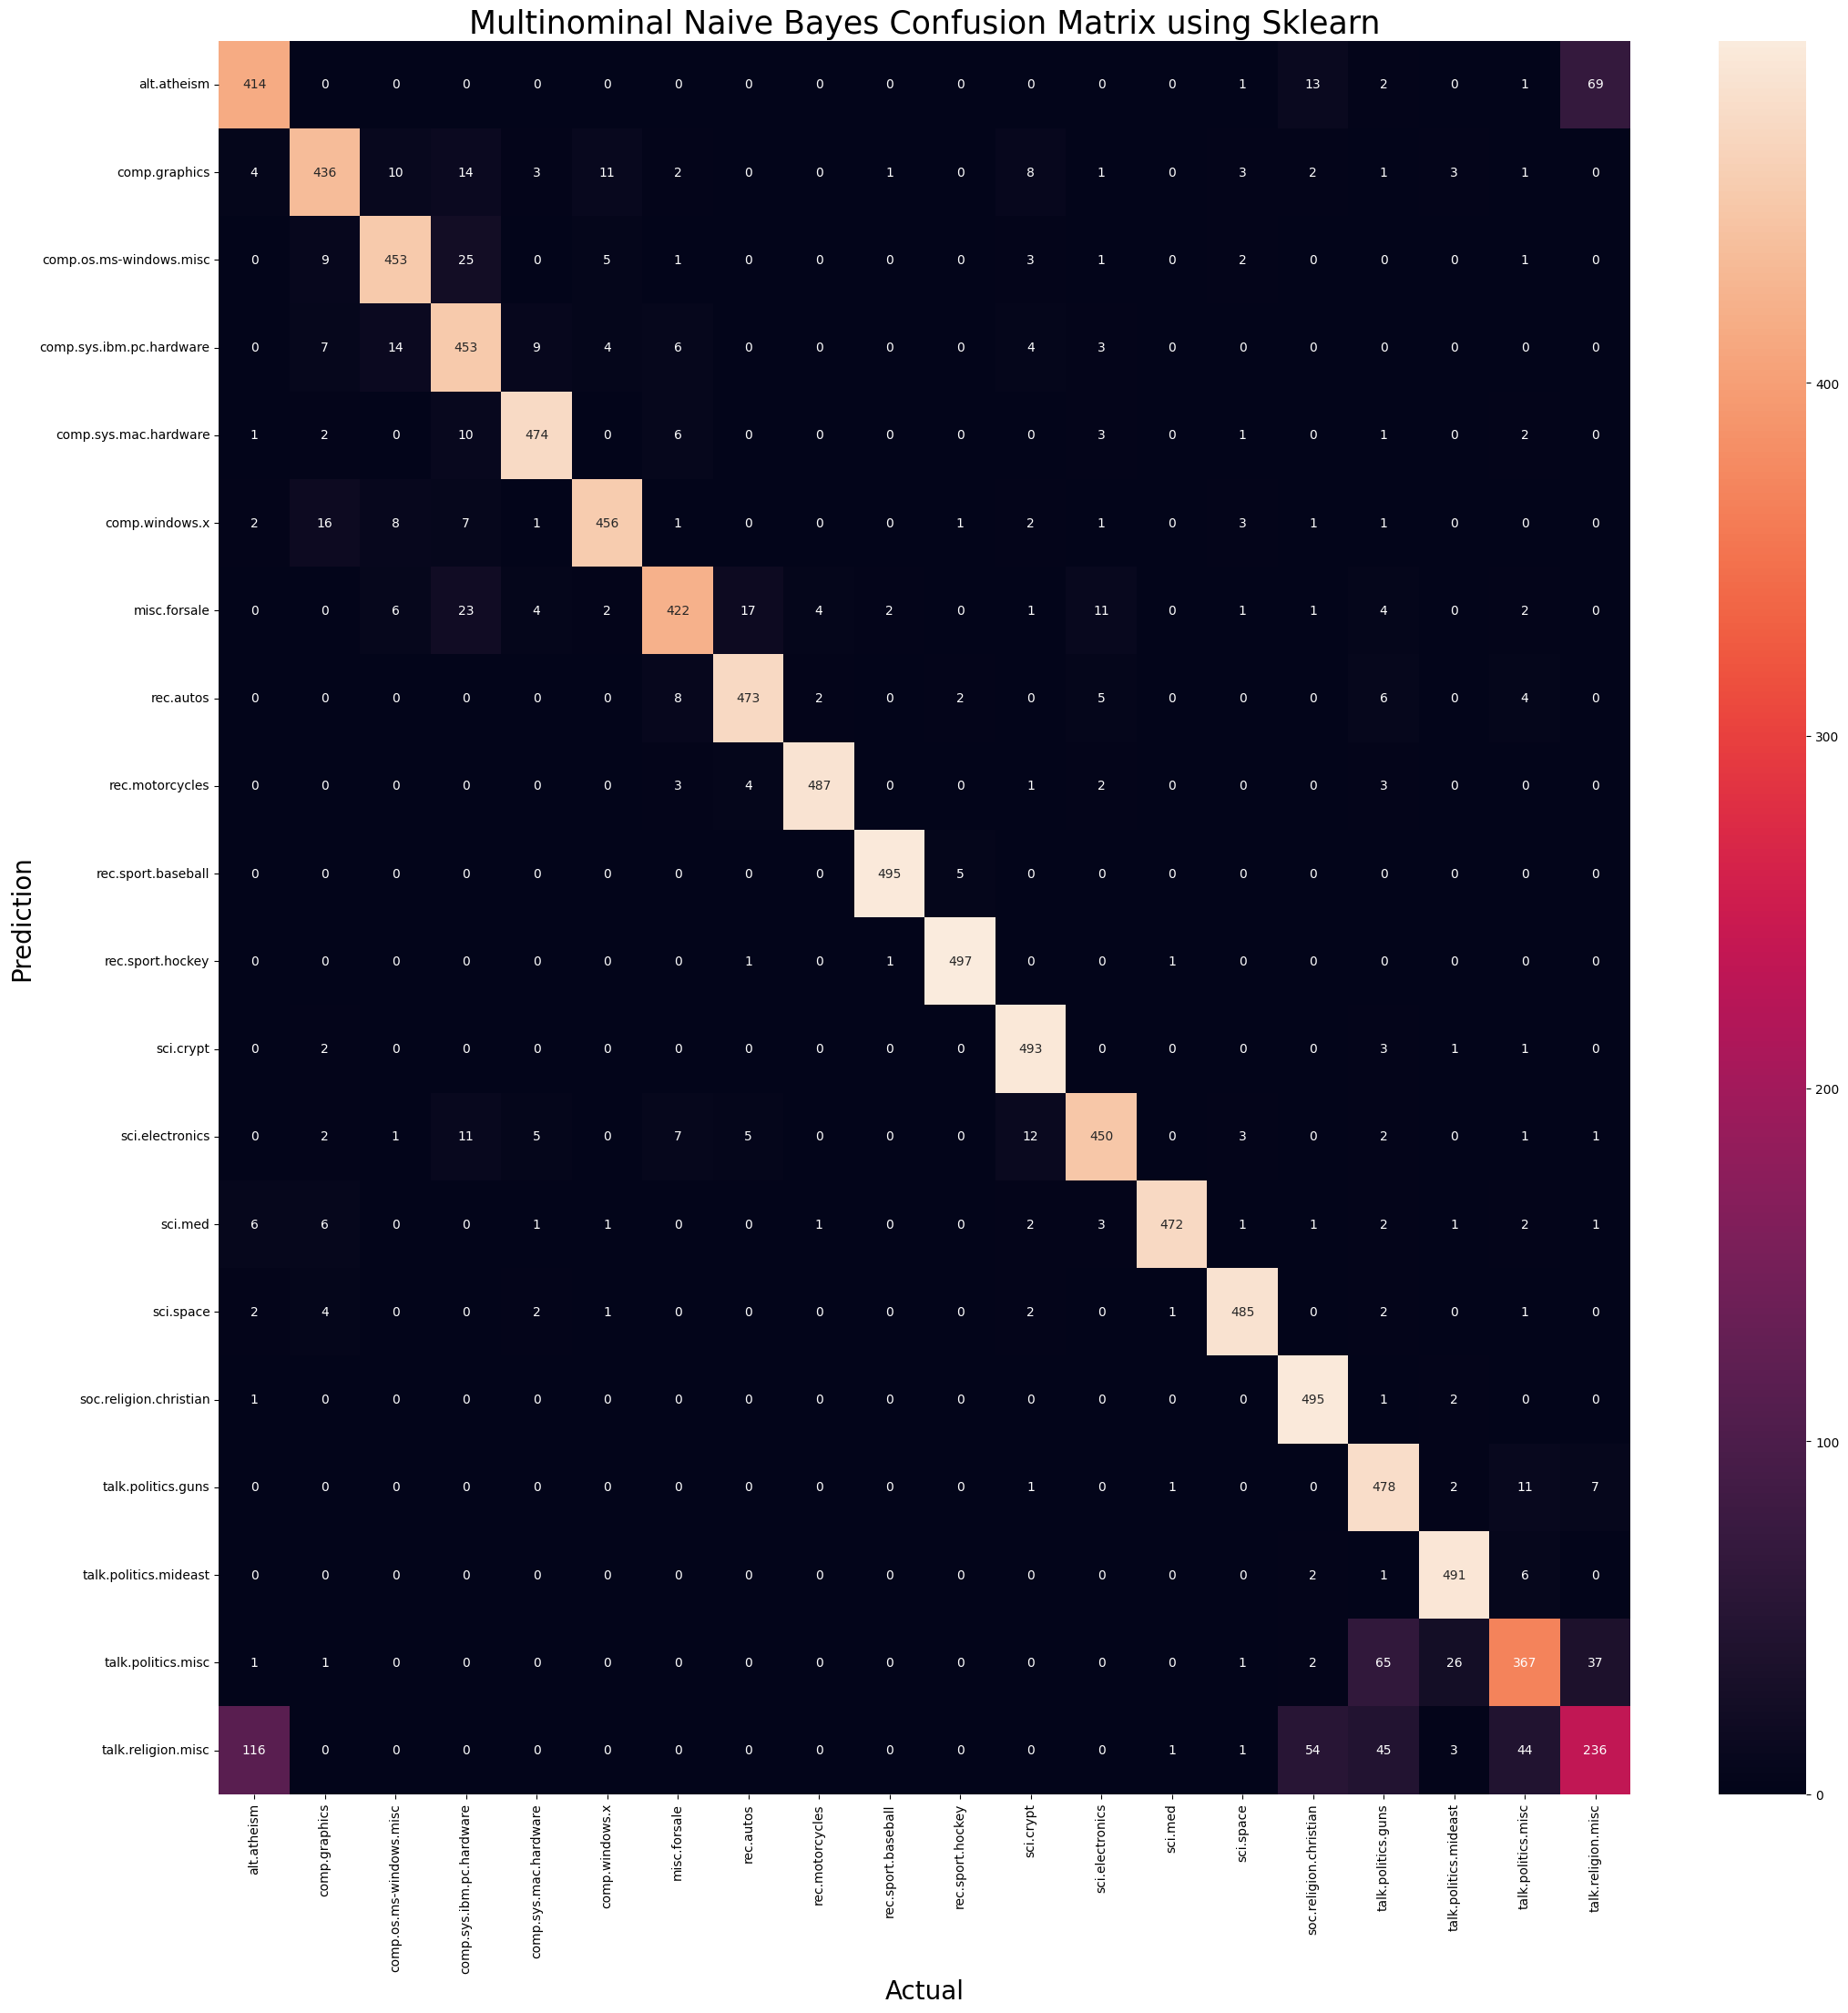

In [82]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(25,25))
sns.heatmap(cm, 
            annot=True,
            xticklabels= classifier.classes_,
            yticklabels= classifier.classes_,fmt='.3g')
plt.ylabel('Prediction',fontsize=20)
plt.xlabel('Actual',fontsize=20)
plt.title('Multinominal Naive Bayes Confusion Matrix using Sklearn',fontsize=25)
plt.show()

## Implementing Multinominal Naive Bayes without any Libraries

In [83]:
class NaiveBayes:
    def __init__(self):
        self.class_probs = {}
        self.word_probs = {}
        self.classes = set()

    def train(self, X, y):
        total_samples = len(y)
        for cls in set(y):
            self.classes.add(cls)
            cls_count = sum(1 for label in y if label == cls)
            self.class_probs[cls] = cls_count / total_samples

            words_in_class = [X[i] for i in range(total_samples) if y[i] == cls]
            word_count = {}
            for word_list in words_in_class:
                for word_index, count in zip(word_list.indices, word_list.data):
                    word_count[word_index] = word_count.get(word_index, 0) + count

            total_words = sum(word_count.values())
            for word_index, count in word_count.items():
                self.word_probs[(word_index, cls)] = count / total_words

    def predict(self, X):
        predictions = []
        for word_list in X:
            max_prob = -1
            predicted_class = None
            for cls in self.classes:
                prob = self.class_probs[cls]
                for word_index, count in zip(word_list.indices, word_list.data):
                    prob *= self.word_probs.get((word_index, cls), 1e-9) ** count
                if prob > max_prob:
                    max_prob = prob
                    predicted_class = cls
            predictions.append(predicted_class)
        return predictions

nb = NaiveBayes()
nb.train(X_train, y_train)

### Classification Report - Multinominal Naive Bayes(without Sklearn)

In [84]:
accuracy = accuracy_score(y_test, nb.predict(X_test))
print(f'Test Accuracy: {accuracy:.2f}')
accuracy = accuracy_score(y_train, nb.predict(X_train))
print(f'Train Accuracy: {accuracy:.2f}')
report = classification_report(y_test, nb.predict(X_test))
print('Classification Report:\n', report)

Test Accuracy: 0.87
Train Accuracy: 0.99
Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.79      0.80      0.79       500
           comp.graphics       0.76      0.81      0.79       500
 comp.os.ms-windows.misc       0.85      0.83      0.84       500
comp.sys.ibm.pc.hardware       0.79      0.80      0.79       500
   comp.sys.mac.hardware       0.88      0.87      0.88       500
          comp.windows.x       0.89      0.88      0.88       500
            misc.forsale       0.86      0.76      0.81       500
               rec.autos       0.91      0.90      0.91       500
         rec.motorcycles       0.95      0.96      0.96       500
      rec.sport.baseball       0.99      0.95      0.97       500
        rec.sport.hockey       0.96      0.98      0.97       500
               sci.crypt       0.98      0.97      0.97       500
         sci.electronics       0.87      0.85      0.86       500
          

### Multinominal Naive Bayes Confusion Matrix Without Sklearn

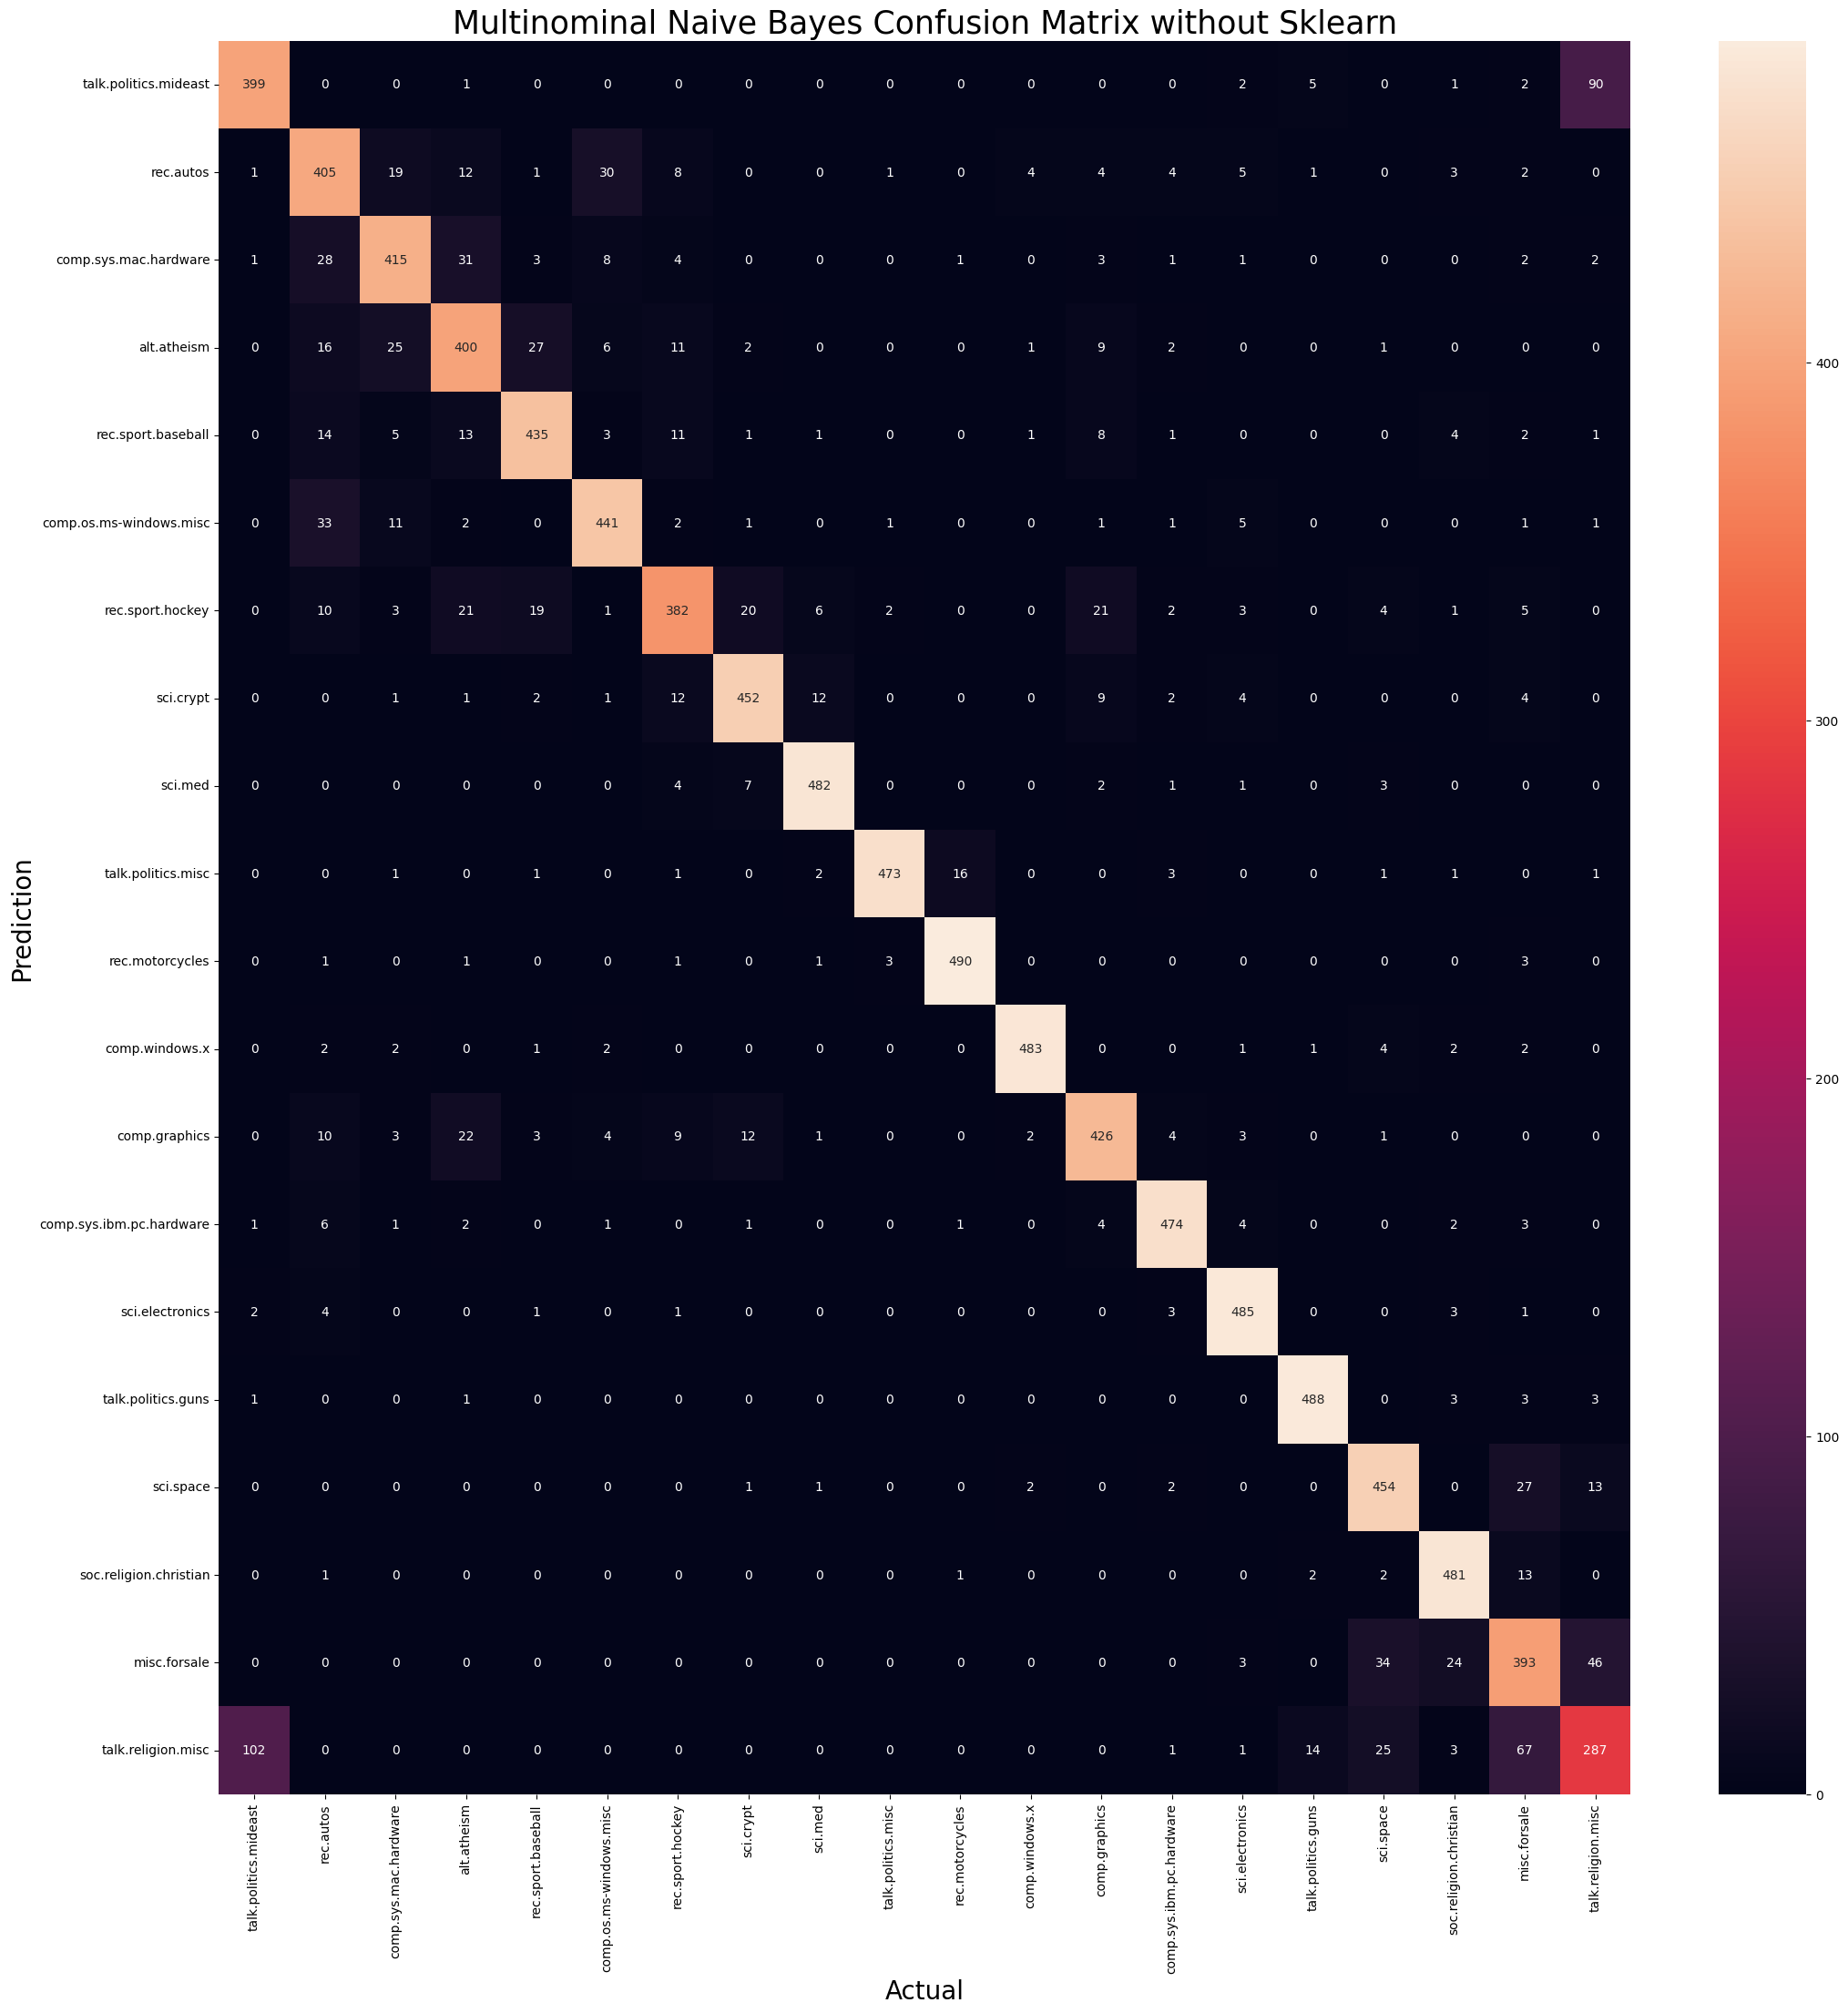

In [87]:
cm = confusion_matrix(y_test, nb.predict(X_test))
plt.figure(figsize=(25,25))
sns.heatmap(cm, 
            annot=True,
            xticklabels= dict.keys(),
            yticklabels= dict.keys(),fmt='.3g')
plt.ylabel('Prediction',fontsize=20)
plt.xlabel('Actual',fontsize=20)
plt.title('Multinominal Naive Bayes Confusion Matrix without Sklearn',fontsize=25)
plt.show()

In [86]:
! pip install tabulate
import pandas as pd
from tabulate import tabulate

models = ['Multinominal NB(using Sklearn)', 'Multinominal NB(without Sklearn)']
test_accuracy = [accuracy_score(classifier.predict(X_test),y_test),accuracy_score(nb.predict(X_test),y_test)]
train_accuracy = [accuracy_score(classifier.predict(X_train),y_train),accuracy_score(nb.predict(X_train),y_train)]

metrics_dict = {
    'Model': models,
    'Test Accuracy': test_accuracy,
    'Train Accuracy': train_accuracy,
}

metrics_df = pd.DataFrame(metrics_dict, index=models)
metrics_df.set_index('Model', inplace=True)
metrics_df = metrics_df.T

print(tabulate(metrics_df, headers='keys', tablefmt='grid'))

+----------------+----------------------------------+------------------------------------+
|                |   Multinominal NB(using Sklearn) |   Multinominal NB(without Sklearn) |
+================+==================================+====================================+
| Test Accuracy  |                         0.90279  |                           0.874587 |
+----------------+----------------------------------+------------------------------------+
| Train Accuracy |                         0.963293 |                           0.986397 |
+----------------+----------------------------------+------------------------------------+
